In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chaosmagpy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [2]:
def dx(ym,xm,f):
    dxm=np.abs(xm[0,1]-xm[0,0])
    der=(np.roll(f,-1,axis=1)-np.roll(f,1,axis=1))/(2*dxm)
    der[:,0]=(f[:,1]-f[:,-2])/(2*dxm)
    der[:,-1] = der[:,0]
    return der
    
def dy(ym,xm,f):
    dym=np.abs(ym[1,0]-ym[0,0])
    der=(np.roll(f,-1,axis=0)-np.roll(f,1,axis=0))/(2*dym)
    der[0,:]=(f[1,:]-f[0,:])/(dym)
    der[1,:] = (f[-1,:]-f[-2,:])/(dym)
    return der

def ddy(ym,xm,f):
    dym=np.abs(ym[1,0]-ym[0,0])
    der=(np.roll(f,1,axis=0)- 2*f +np.roll(f,-1,axis=0))/(dym**2)
    der[0,:]=der[1,:]
    der[-1,:]=der[-2,:]
    return der

def ddx(ym,xm,f):
    dxm =np.abs(xm[0,1]-xm[0,0])
    der   = (np.roll(f,1,axis=1) - 2*f + np.roll(f,-1,axis=1)) / (dxm**2)
    der[:,0]=(f[:,1]-2*f[:,0]+f[:,-2])/(dxm**2)
    der[:,-1]=der[:,0]
    return der

def ddxy(ym,xm,f):
    df_dx = dx(ym,xm,f)
    ddf_dxy=dy(ym,xm,df_dx)
    return ddf_dxy

def detH(ddx,ddy,ddxy):
    derH=(ddx*ddy)#-(ddxy*ddxy)
    return derH


In [16]:
def find_cross(x, y, fun1,fun2,lev,threshold):
 # 筛选 cross logic
    #get the path locations of many point.
    #delete ±5 near the pole
    #compare the location in two contour
    #if two points(from different contour) in the 1 x 1 degree grids. append the avg of location
    #so we pick all the cross point. but some point are very nearly
    #then need to delete the same point
    #compare the crosspoint with it self.
    #if some point is near the useing point, we mark it and at the end cauculate the avg location
    #the nearly means in 5 degrees.
    #
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])
    points_dx = []
    for path in c_fx.get_paths():
        verts = path.vertices  # (N, 2)
        points_dx.extend(verts)
    points_dy = []
    for path in c_fy.get_paths():
        verts = path.vertices
        points_dy.extend(verts)

    points_dx = np.array(points_dx)
    points_dy = np.array(points_dy)

    cross_lat=[]
    cross_lon=[]
    for m in range(0, len(points_dx[:, 0])):
        px_lat = points_dx[m, 1]
        px_lon = points_dx[m, 0]
        if (px_lat > 5) & (px_lat < 175):   # bonderay ±3 degree
            for n in range(0, len(points_dy)):
                py_lat = points_dy[n, 1]
                py_lon = points_dy[n, 0]
                if (np.abs(py_lat - px_lat) < 1) & (np.abs(py_lon - px_lon) < 1): # 1degree grids
                    cross_lat.append((py_lat + px_lat)/2)
                    cross_lon.append((py_lon + px_lon)/2)
    cross_lon=np.array(cross_lon)
    cross_lat=np.array(cross_lat)

    latitudes=cross_lat
    longitudes=cross_lon
    threshold=5
    n = len(latitudes)
    used = np.zeros(n, dtype=bool)  # marker
    grouped_lats = []
    grouped_lons = []

    for i in range(n):
        if used[i]:
            continue 
        lat_sum = latitudes[i]
        lon_sum = longitudes[i]
        count = 1
        used[i] = True
        for j in range(i+1, n):
            if used[j]:
                continue
            if (abs(latitudes[j] - latitudes[i]) < threshold) and (abs(longitudes[j] - longitudes[i]) < threshold):
                lat_sum += latitudes[j]
                lon_sum += longitudes[j]
                count += 1
                used[j] = True  # marker
                
        grouped_lats.append(lat_sum / count)
        grouped_lons.append(lon_sum / count)
    return np.array(grouped_lats), np.array(grouped_lons)

In [17]:
def find_detH_Saddle(DETH,lat_cross,lon_cross):
    saddle_lat = []
    saddle_lon = []
    Extrema_lat = []
    Extrema_lon = []
    for im in range(0, len(lat_cross)):
            mi_lat = int(round(lat_cross[im]))
            mi_lon = int(round(lon_cross[im]))
            if DETH[mi_lat,mi_lon] >= 0:
                Extrema_lat.append(mi_lat)
                Extrema_lon.append(mi_lon)
            else:
                saddle_lat.append(mi_lat)
                saddle_lon.append(mi_lon)
    return np.array(saddle_lat),np.array(saddle_lon),np.array(Extrema_lat),np.array(Extrema_lon)

In [18]:
def mean_F(f,thetam):
    theta_rad = np.deg2rad(thetam)
    sin=np.sin(theta_rad)
    product_sum = np.sum(f[30:151, :] * sin[30:151, :])
    C = np.sum(sin[30:151, :])
    mean=product_sum/C
    return mean

def calculate_integral(B):
    #计算归一化 积分
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)  # 经度范围
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)  # 纬度范围

    integrals = [0, 0]  
    theta_min = np.deg2rad(25)   
    theta_max = np.deg2rad(155)  
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],  
        [(0, 2 * np.pi), (theta_max, np.pi)] ]
    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and region[1][0] <= (theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta
    integral = sum(integrals)
    return integral
#计算Fout
def F_boundary(constant,B,B_t0):
    Fup = calculate_integral(B)
    Fdown = calculate_integral(B_t0)
    F_out = Fup / Fdown
    #F边界
    boundaryF=constant*F_out
    return boundaryF

In [19]:
def read_gauss_coeffs(filename, target_year, lmax=25):
    """
    从 pfm9k 格式的文件中读取指定年份的高斯系数，
    输出 gsh 和 hsh 按 (l, m) 顺序排列。
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    years = list(map(float, lines[0].strip().split()))
    if target_year not in years:
        raise ValueError(f"目标年份 {target_year} 不在数据中")
    idx = years.index(target_year)

    coeff_lines = lines[1:len(lines)]
    coeffs = [list(map(float, line.strip().split())) for line in coeff_lines]

    coeffs_at_year = [row[idx] for row in coeffs]  
    gsh = []
    hsh = []
    i = 0
    for l in range(1, lmax + 1):
        for m in range(0, l + 1):
            gsh.append(coeffs_at_year[i])
            i+=1
        for m in range(0, l + 1):
            if m == 0:
                hsh.append(0.0)
            else:
                hsh.append(coeffs_at_year[i])
                i += 1
    return np.array(gsh), np.array(hsh)

# 计算主磁场
def magnetic_field(gsh,hsh,lmax,r,lats,lons):
    a=6371.2
    pi            = math.pi
    # lats          =  np.linspace(1., 179., num=181)
    # lons          =  np.linspace(-180., 180., num=181)
    lons2d,lats2d = np.meshgrid(lons,lats)
    phi           = lons2d
    cost2d        = np.cos((lats2d)*np.pi/180)
    i             = 0
    br            = np.zeros((cost2d.shape))
    bphi          = np.zeros((cost2d.shape))
    btheta        = np.zeros((cost2d.shape))
    for l in np.arange(1,lmax+1,1):
        for m in np.arange(0,l+1,1):
            g=gsh[i]
            h=hsh[i]
            #calculate schmidt
            if m  == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0)**m)*np.sqrt(2.0*math.factorial(l-m)/math.factorial(l+m))
            lagendre     = scipy.special.lpmv(m, l, cost2d)
            lagendre_    = scipy.special.lpmv(m, l-1, cost2d)
            div_lagendre = (l*cost2d*lagendre-(l+m)*lagendre_)/np.sqrt(1-cost2d**2)
            br           = br     + schmidt*(float(l)+1.0)*((a/r)**(l+2))*lagendre*(g*np.cos(float(m)*phi*pi/180.0)
                                                                                    +h*np.sin(float(m)*phi*pi/180.0))
            bphi         = bphi   + schmidt*(m/np.sin((lats2d)*pi/180))*((a/r)**(l+2))*lagendre*(-g*np.sin(float(m)*phi*pi/180.0)
                                                                                                    +h*np.cos(float(m)*phi*pi/180.0))
            btheta       = btheta + schmidt*((a/r)**(l+2))*(div_lagendre)*(g*np.cos(float(m)*phi*pi/180.0)+h*np.sin(float(m)*phi*pi/180.0))
            i+=1
    return br,bphi,btheta,lons2d,lats2d

# Snapshot IN CHAOS

In [20]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')

time = cp.data_utils.mjd2000(2020, 1, 1)  # modified Julian date
B_radius, B_theta, B_phi = model.synth_values_tdep(time, radiusm, thetam, phim)
F2020 = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
Fo2020=calculate_integral(F2020)

D:\Anaconda\envs\Saddle\Lib\site-packages\chaosmagpy\chaos.py:2873: UserWarning: Missing ionospheric field coefficients: 'model_ion'
  warnings.warn(f'Missing ionospheric field coefficients: {err}')


C:\Users\yue-y\AppData\Local\Temp\ipykernel_21284\3394899881.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.75, 1])


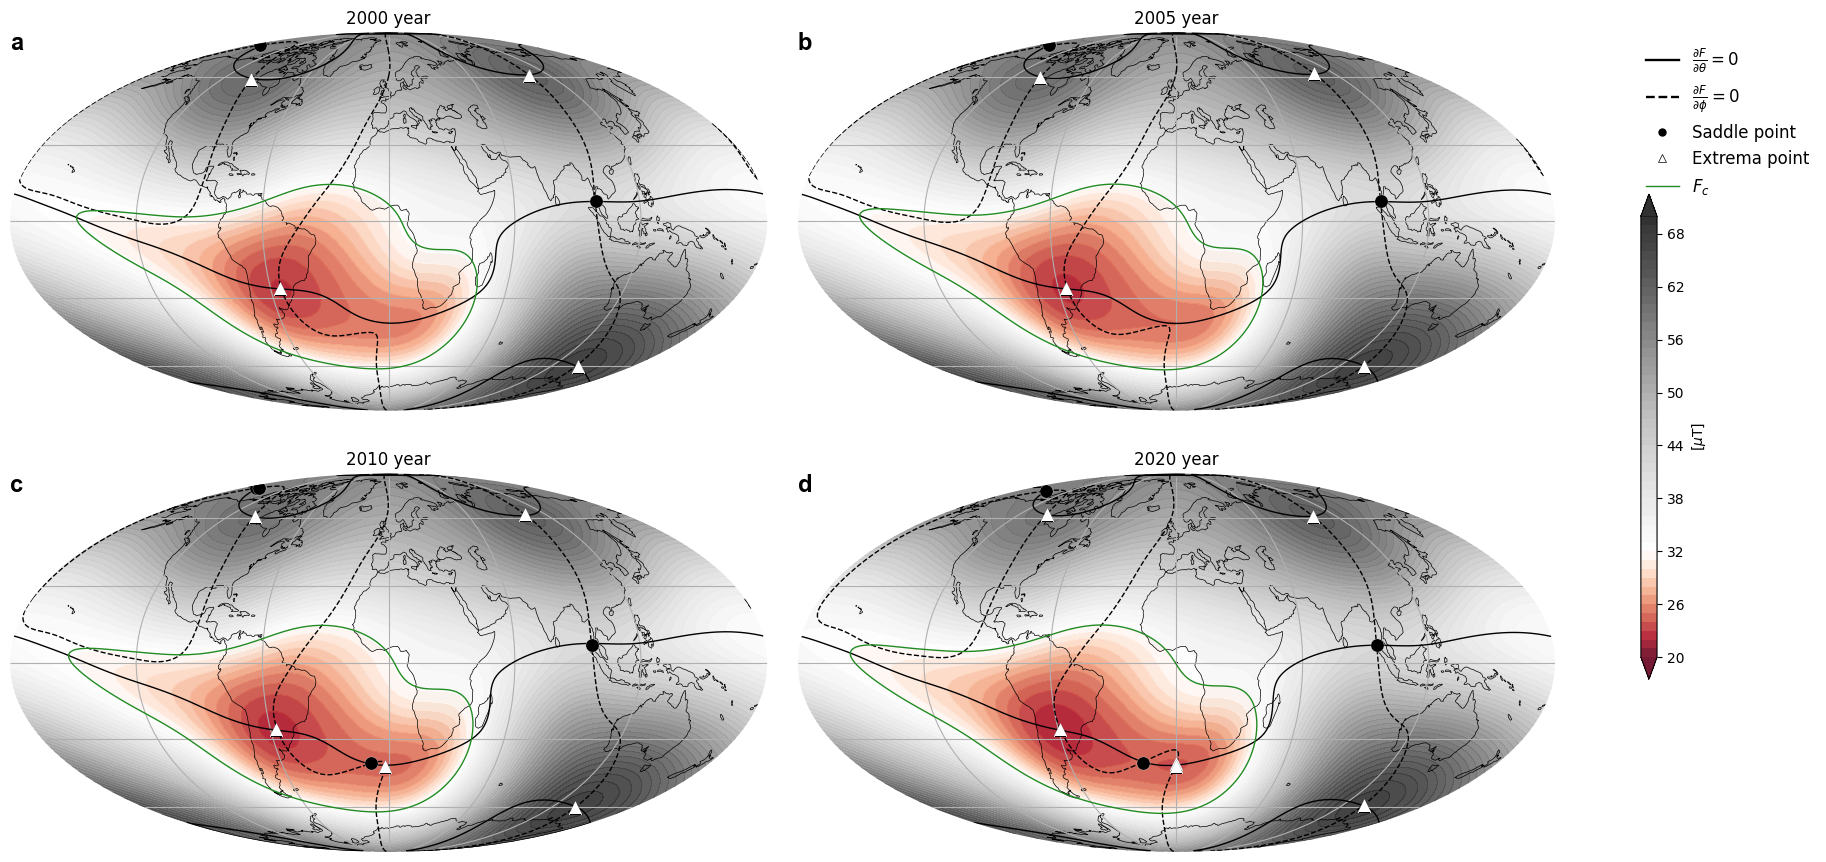

In [21]:
import matplotlib.colors as mcolors
records_max = []
records_min = []
records_saddle = []
n=1

Cmap="RdGy"# 'PuOr_r'
linecolor="forestgreen"
vmin = 20
vmax = 70

markersize = 90
SaddleColor="k"
SaddleMarker="o"
ExtremaColor="white"
ExtremaMarker="^"

fontweight='bold'
fontname='Arial'
fontsize=17


snapshotTIME=[2000,2005,2010,2020]
fig, axs = plt.subplots(2, 2, figsize=(21, 9), subplot_kw={'projection': ccrs.Mollweide()})
fig.subplots_adjust(hspace=0.2, wspace=0.1)

legend_elements = [
    Line2D([0], [0], color='k', lw=1.7, label=r'$\frac{\partial F}{\partial \theta} = 0$'),
    Line2D([0], [0], color='k', lw=1.7, label=r'$\frac{\partial F}{\partial \phi} = 0$', linestyle='dashed'),
    Line2D([0], [0], marker=SaddleMarker, color=SaddleColor, label='Saddle point', markersize=5, linestyle='None'),
    Line2D([0], [0], color=ExtremaColor, marker=ExtremaMarker, label='Extrema point', markersize=6, linestyle='None', markeredgecolor='k', markeredgewidth=0.5),
    Line2D([0], [0], color=linecolor, lw=1 , label=r'$F_c$')
]

text=["a","b","c","d"]
for i in range(0,len(snapshotTIME)):
    yr=snapshotTIME[i]
    # CHAOS-8
    time = cp.data_utils.mjd2000(yr, 1, 1)  # modified Julian date
    B_radius, B_theta, B_phi = model.synth_values_tdep(time, radiusm, thetam, phim)
    F = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
    Fout=calculate_integral(F)
    Fc =32 * (Fout/ Fo2020)

    vcenter = Fc  # 想让这个值为白色
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    
    F_real = F
    d_x = dx(thetam, phim, F_real)
    d_y = dy(thetam, phim, F_real)
    dd_x = ddx(thetam, phim, F_real)
    dd_y = ddy(thetam, phim, F_real)
    dd_xy = ddxy(thetam, phim, F_real)
    lat_cross, lon_cross = find_cross(phi, theta, d_x, d_y, 0, 2)
    DETH = detH(dd_x, dd_y, dd_xy)
    H_S_lat, H_S_lon, H_E_lat, H_E_lon = find_detH_Saddle(DETH, lat_cross, lon_cross)
    

    
    ax = axs[i // 2, i % 2]  # 访问二维子图数组
    ax.set_global()
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', linewidth=0.5)
    # ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    C = np.linspace(20,70, 51)
    cb = ax.contourf(phi, 90 - theta, F_real,C,  cmap=Cmap, transform=ccrs.PlateCarree(), extend="both",alpha=0.9,norm=norm)
    C1 = np.linspace(20, 60, 40)
    # cb2 = ax.contour(phi, 90 - theta, F_real,C1,  colors="white", transform=ccrs.PlateCarree(), extend="both",alpha=0.5)
    
    ax.scatter(H_E_lon, 90 - H_E_lat, color=ExtremaColor, marker=ExtremaMarker, s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="k",linewidths=0.1)
    ax.scatter(H_S_lon, 90 - H_S_lat, color=SaddleColor, marker=SaddleMarker,s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="white",linewidths=0.2)
    
    ax.contour(phi, 90 - theta, d_y, levels=[0], colors='k', linewidths=1, transform=ccrs.PlateCarree())
    ax.contour(phi, 90 - theta, d_x, levels=[0], colors='k', linewidths=1, transform=ccrs.PlateCarree(), linestyles='dashed')
    ax.contour(phi, 90 - theta, F_real, levels=[Fc], colors=linecolor, linewidths=1, transform=ccrs.PlateCarree())
    
    ax.set_title(f'{yr} year')
    ax.text(0, 1, text[i], transform=ax.transAxes, fontsize=fontsize, fontweight=fontweight,fontname=fontname, va='top')
    # cb = plt.colorbar(cb, orientation='vertical', pad=0.02, aspect=30)
    # cb.set_label(r'[$\mu$T]')
cbar = fig.colorbar(cb, ax=axs, orientation='vertical', shrink=0.7, pad=0.05,aspect=30)
cbar.set_label(r'[$\mu$T]')
# 设置 legend 到其中一个子图即可（如 ax=axs[0,0]）
# axs[0, 0].legend(handles=legend_elements, loc='lower left', fontsize=10)

axs[0, 1].legend(
    handles=legend_elements,
    loc='upper left',
    bbox_to_anchor=(1.10, 1),  # 控制位置，x越大越靠右，y越大越靠上
    frameon=False,
    fontsize=12
)
plt.tight_layout(rect=[0, 0, 0.75, 1]) 
# plt.savefig(r'D:\\work\\work_saddle\\Latex_saddle\\Fig\\New-color\\5_snapshot.png', dpi=300, bbox_inches='tight')
